In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
TRAINING_SAMPLES = 15000
VALIDATION_SAMPLES = 6000
MAX_WORDS = 10000

In [4]:
train_data = pd.read_csv('../Data/train.csv')

nan_idx = train_data[pd.isnull(train_data.text)].index.tolist()
train_data.loc[nan_idx, 'text'] = ' '

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_WORDS)
tfidf_vectorizer.fit(train_data.text[:TRAINING_SAMPLES])

x_train = tfidf_vectorizer.transform(train_data.text[:TRAINING_SAMPLES])
y_train = train_data.label[:TRAINING_SAMPLES]

x_val = tfidf_vectorizer.transform(train_data.text[TRAINING_SAMPLES:TRAINING_SAMPLES + VALIDATION_SAMPLES])
y_val = train_data.label[TRAINING_SAMPLES:TRAINING_SAMPLES + VALIDATION_SAMPLES]

In [25]:
# embedding_index = {}
# with open('glove/glove.6B.100d.txt', encoding="utf8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embedding_index[word] = coefs

# embedding_dim = 100

# embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
# for word, i in word_index.items():
#     embedding_vector = embedding_index.get(word)
#     if i < max_words:
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector
# print('Glove załadowane!')

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(MAX_WORDS,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 321,121
Trainable params: 321,121
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 5800 samples
Epoch 1/20
15000/15000 [==============================] - 3s 181us/step - loss: 0.6017 - acc: 0.8372 - val_loss: 0.4904 - val_acc: 0.9191
Epoch 2/20
15000/15000 [==============================] - 2s 107us/step - loss: 0.3923 - acc: 0.9351 - val_loss: 0.3150 - val_acc: 0.9284
Epoch 3/20
15000/15000 [==============================] - 2s 107us/step - loss: 0.2393 - acc: 0.9523 - val_loss: 0.2137 - val_acc: 0.9405
Epoch 4/20
15000/15000 [==============================] - 2s 108us/step - loss: 0.1517 - acc: 0.9643 - val_loss: 0.1598 - val_acc: 0.9457
Epoch 5/20
15000/15000 [==============================] - 2s 108us/step - loss: 0.1016 - acc: 0.9744 - val_loss: 0.1327 - val_acc: 0.9503
Epoch 6/20
15000/15000 [==============================] - 2s 112us/step - loss: 0.0698 - acc: 0.9829 - val_loss: 0.1221 - val_acc: 0.9505
Epoch 7/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.0489 - acc: 0.9882 - val_loss: 0.1108 - v

In [28]:
model.save_weights('pre_trained_model_new.h5')

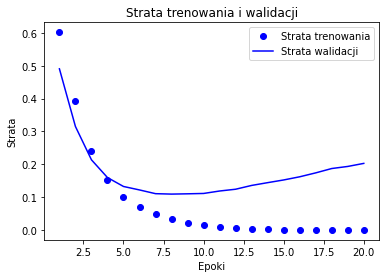

In [29]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')

plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

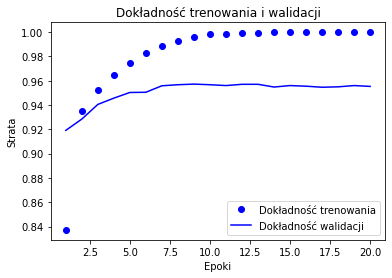

In [30]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')

plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

In [31]:
test_data = pd.read_csv('../Data/test.csv')

nan_idx = test_data[pd.isnull(test_data.text)].index.tolist()
test_data.loc[nan_idx, 'text'] = ' '

x_test = tfidf_vectorizer.transform(test_data.text)
y_test = test_data.label

model.evaluate(x_test, y_test)

5200/5200 [==============================] - 1s 153us/step


[4.843096367762639, 0.6317307949066162]